# Actividad 3 - Alex Herrerías Ramírez

El notebook se va a dividir en 3 apartados principales:
- Carga de datos y un pequeño análisis inicial
- Un modelo de clasificación para predecir el tipo de alojamiento (room_type) 
- Un modelo de regresión para predecir el precio (price), utilizando el dataset de AirBnB.

Primero cargaremos todas las librerías que vamos a usar a lo largo de la práctica.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC, LinearSVC, SVR, LinearSVR
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score, confusion_matrix, ConfusionMatrixDisplay

## 1. Carga y Análisis Estadístico inicial
Cargamos el dataset y realizamos una limpieza similar a la Actividad 1, centrándonos en detectar outliers.

In [3]:
try:
    df = pd.read_csv("airbnb.csv")
except FileNotFoundError:
    print("No se encontró el archivo")

df.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000,13321.000000
mean,40.420730,-3.697268,69.171834,3.010885,22.986037,1.520329,7.605885,205.867202
std,0.020344,0.023832,103.721126,12.835619,38.406006,1.852367,19.619972,126.968961
min,40.331888,-3.863907,9.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,40.410090,-3.707856,31.000000,1.000000,1.000000,0.110000,1.000000,84.000000
50%,40.418731,-3.701602,53.000000,2.000000,7.000000,0.780000,2.000000,247.000000
75%,40.427997,-3.693818,80.000000,3.000000,28.000000,2.320000,4.000000,321.000000
max,40.562736,-3.526821,7700.000000,1125.000000,446.000000,17.210000,145.000000,365.000000


Comprobamos los nulos, observamos que no existen por lo que nos podemos despreocupar de este apartado

In [4]:
print("Valores nulos por columna:")
print(df.isnull().sum())

Valores nulos por columna:
neighbourhood_group               0
neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64


Comprobamos los tipos de los datos, observamos que también estan formateados correctamente, por lo que solo nos queda centrarnos en los outliers

In [5]:
print("\nTipos de datos:")
print(df.dtypes)


Tipos de datos:
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object


### Limpieza de Outliers y Estudio Estadístico
Principalmente usaremos las variables `price`, `minimum_nights` y `calculated_host_listings_count` para el modelo, dado que la limpieza de outliers es importante para obtener buenos resultados en estos modelos, he decidido utilizar dos métodos de limpieza y decidir cual sera el mas óptimo: el Rango Intercuartílico (IQR) y el corte por Percentiles.


In [6]:
columnas = ['price', 'minimum_nights', 'calculated_host_listings_count']

print(f"Registros totales: {df.shape[0]}")
print(df[columnas].describe().loc[['min', 'max', 'mean', '50%']])

Registros totales: 13321
            price  minimum_nights  calculated_host_listings_count
min      9.000000        1.000000                        1.000000
max   7700.000000     1125.000000                      145.000000
mean    69.171834        3.010885                        7.605885
50%     53.000000        2.000000                        2.000000


Calculamos el IQR en las columnas, observamos que tenemos una perdida de datos del **22.5%** 

In [7]:
df_iqr = df.copy()

for col in columnas:
    # calculo del IQR
    Q1 = df_iqr[col].quantile(0.25)
    Q3 = df_iqr[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_superior = Q3 + 1.5 * IQR
    
    # filtramos
    n_antes = df_iqr.shape[0]
    df_iqr = df_iqr[df_iqr[col] <= limite_superior]
    n_despues = df_iqr.shape[0]

print(f"Registros usando IQR: {df_iqr.shape[0]}")
datos_borrados_IQR = (df.shape[0] - df_iqr.shape[0])/df.shape[0]*100
print(f"Datos borrados: {datos_borrados_IQR:.2f}%")

Registros usando IQR: 10318
Datos borrados: 22.54%


Calculamos el percentil 99 en las columnas, observamos que tenemos una perdida de datos del **1.99%**

In [8]:
df_p99 = df.copy()

for col in columnas:
    # calculo el percentil 99
    limite_99 = df_p99[col].quantile(0.99)
    
    # filtramos
    n_antes = df_p99.shape[0]
    df_p99 = df_p99[df_p99[col] <= limite_99]
    n_despues = df_p99.shape[0]

print(f"Registros usando 99%: {df_p99.shape[0]}")
datos_borrados_99 = (df.shape[0] - df_p99.shape[0])/df.shape[0]*100
print(f"Datos borrados: {datos_borrados_99:.2f}%")

Registros usando 99%: 13056
Datos borrados: 1.99%


Dado que el método IQR elimna un **22.5%** de los registros, se ha decido seguir con  una limpieza basada en el **Percentil 99%** que elimina outliers extremos sin borrar una cantidad extrema de datos

## 2. Clasificación:
Una vez tenemos los datos preparados tras la limpieza, nuestro objetivo es clasificar la variable `room_type` utilizando el resto de características disponibles.

Procedemos a preparar los datos:
1. **Codificación de la variable objetivo:** Transformamos `room_type` a valores numéricos.
2. **Transformación de variables:** Aplicamos `StandardScaler` a las variables numéricas y `OneHotEncoder` a las categóricas (`neighbourhood` y `neighbourhood_group`) para que puedan ser procesadas por los modelos SVM.
3. **División del conjunto de datos:** Separamos en *train* y *test*  con un porcentaje de 80/20 siguiendo los ejemplos de la asignatura.

In [9]:
# separamos la variable objetivo
X_clasi = df_p99.drop(['room_type'], axis=1)
y_clasi = df_p99['room_type']

# codificamos la variable objetivo
le = LabelEncoder()
y_clasi_codificado = le.fit_transform(y_clasi)

# separamos las columnas por numericas y categoricas
num_attr = X_clasi.select_dtypes(include=[np.number]).columns.tolist()
cat_attr = ['neighbourhood_group', 'neighbourhood']

#  para las columnas numericas aplicamos el StandardScaler, para las categoricas OneHotEncoder
clasi_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_attr),
        ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attr),
    ])

X_clasi_final = clasi_pipeline.fit_transform(X_clasi)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_clasi_final, y_clasi_codificado, test_size=0.2, random_state=42)

### Entrenamiento de modelos base
Entrenaremos los dos modelos con los parámetros por defecto, observaremos los resultados y optimizaremos posteriormente:
1. **LinearSVC**: Modelo SVM lineal optimizado.
2. **SVC**: Modelo SVM estándar.

In [10]:
# LinearSVC
svc_linear = LinearSVC(dual=False, random_state=42)
svc_linear.fit(X_train_c, y_train_c)
precision_linear = accuracy_score(y_test_c, svc_linear.predict(X_test_c))
print(f"Precisión LinearSVC: {precision_linear:.4f}")

# SVC
svc = SVC(kernel='rbf', random_state=42)
svc.fit(X_train_c, y_train_c)
precision_svc = accuracy_score(y_test_c, svc.predict(X_test_c))
print(f"Precisión SVC: {precision_svc:.4f}")

Precisión LinearSVC: 0.8725
Precisión SVC: 0.8974


### Afinación de hiperparámetros para SVC
Optimizaremos los hiperparámetros $C$ y $\gamma$ del modelo SVC.

Realizaremos dos búsquedas secuenciales como se nos indica en el ejercicio:
1. **Primera búsqueda:** Exploramos un rango amplio de valores para poder conseguir un rango pequeño.

In [11]:
rango_C = np.logspace(-2, 3, 6) 
rango_G = np.logspace(-3, 2, 6)

param_grid_1 = dict(gamma=rango_G, C=rango_C)

# conf del GridSearchCV para clasificacion en general, uso n_jobs de 16 ya que mi procesador tiene 16 hilos si da error bajarlo o quitarlo directamente
grid_1 = GridSearchCV(SVC(kernel='rbf'), param_grid_1, cv=3, scoring='accuracy', n_jobs=16)
grid_1.fit(X_train_c, y_train_c)

print(f"Mejores parámetros: {grid_1.best_params_}")
print(f"Mejor precisión: {grid_1.best_score_:.4f}")

Mejores parámetros: {'C': np.float64(100.0), 'gamma': np.float64(0.01)}
Mejor precisión: 0.8956


### Afinación de hiperparámetros
Dado que los mejores hiperparámetros se encuentran alrededor de **$C=100$** y **$\gamma=0.01$**, realizaremos una segunda búsqueda usando una escala lineal:

* Para $C$: usaremos valores en el intervalo `[50, 150]`.
* Para $\gamma$: usaremos valores en el intervalo `[0.005, 0.015]`.

In [12]:
mejor_C = 100
mejor_G = 0.01

rango_C_final = [60, 80, 100, 120, 140]
rango_G_final = np.linspace(0.006, 0.014, 5)

param_grid_2 = dict(gamma=rango_G_final, C=rango_C_final)
grid_2 = GridSearchCV(SVC(kernel='rbf'), param_grid_2, cv=3, scoring='accuracy', n_jobs=16)
grid_2.fit(X_train_c, y_train_c)

print(f"Mejores parámetros: {grid_2.best_params_}")
print(f"Mejor precisión: {grid_2.best_score_:.4f}")

# evaluación final en el conjunto de test
modelo_final = grid_2.best_estimator_
print(f"Precisión en Test: {modelo_final.score(X_test_c, y_test_c):.4f}")

Mejores parámetros: {'C': 60, 'gamma': np.float64(0.014)}
Mejor precisión: 0.8968
Precisión en Test: 0.8970


Antes de analizar los resultados, creamos también una matríz de confusión para poder observar exactamente como ha fallado el modelo

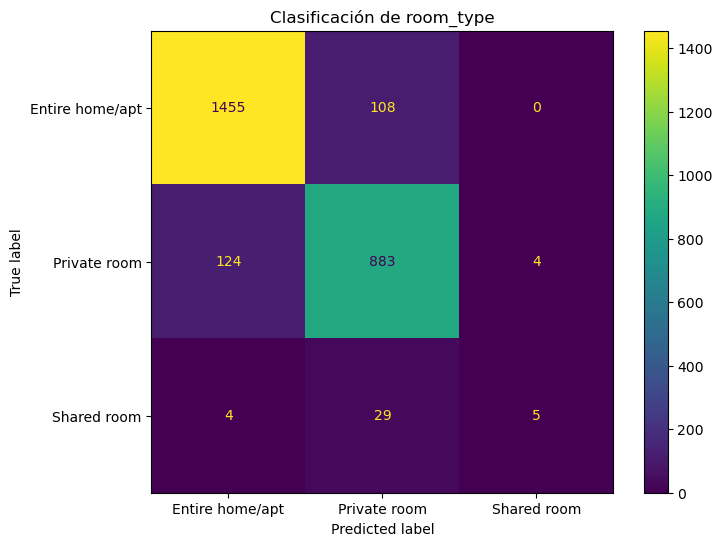

In [13]:
# matriz de confusión
cm = confusion_matrix(y_test_c, modelo_final.predict(X_test_c))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)

# dispplot
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax)
plt.title('Clasificación de room_type')
plt.show()

### Resultados de clasificación
Tras entrenar y optimizar el modelo para predecir el tipo de alojamiento se han obtenido los siguientes resultados:
- Modelo Óptimo: El clasificador SVC superó al modelo lineal con una precisión del 89.70%.
- Hiperparámetros: La configuración final tras el Grid Search fue $C=60$ y $\gamma=0.014$.
- Análisis de la Matriz de Confusión: 
    - Aciertos: El modelo consigue indentificar con una buena precisión las categorías mayoritarias.
    - Errores: El modelo confunde las habitaciones compartidas y privadas.

## 3. Regresión

Antes de empezar a entrenar el modelo, debemos hacer un estudio para determinar si incluir la variable `neighbourhood` como nos indica el ejercicio.

Para ello vamos a realizar una comparativa cruzada probando los dos algoritmos en dos escenarios diferentes:
1.  Con todas las variables incluyendo `neighbourhood`.
2.  Sin la variable `neighbourhood`.

In [14]:
y_reg = df_p99['price']

# modelo simplificado
X_no_neigh = df_p99.drop(['price', 'neighbourhood'], axis=1)
cols_num_no = X_no_neigh.select_dtypes(include=[np.number]).columns.tolist()
cols_cat_no = ['neighbourhood_group', 'room_type']

# modelo completo
X_completo = df_p99.drop(['price'], axis=1)
cols_num_completo = X_completo.select_dtypes(include=[np.number]).columns.tolist()
cols_cat_completo = ['neighbourhood_group', 'neighbourhood', 'room_type'] 

# pipelines
pipe_no_neigh = ColumnTransformer([
    ("num", StandardScaler(), cols_num_no),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cols_cat_no)
])
pipe_all = ColumnTransformer([
    ("num", StandardScaler(), cols_num_completo),
    ("cat", OneHotEncoder(handle_unknown='ignore'), cols_cat_completo)
])

X_transformado_no = pipe_no_neigh.fit_transform(X_no_neigh)
X_transformado_all = pipe_all.fit_transform(X_completo)

# parametros para el bucle de evaluación 
modelos = [
    ("LinearSVR", LinearSVR(random_state=42, max_iter=20000)), 
    ("SVR", SVR())
]
escenarios = [
    ("Sin neighbourhood", X_transformado_no),
    ("Con neighbourhood", X_transformado_all)
]
mejor_resultado = float("inf")
nombre_modelo_final = ""
mejor_escenario = ""

# evaluamos los modelos, al igual que en clasificación uso n_jobs=16 si daba error quitarlo aqui también
for nombre_modelo, modelo in modelos:
    for nombre_escenario, X_datos in escenarios:
        resultados = cross_val_score(modelo, X_datos, y_reg, 
                               scoring="neg_root_mean_squared_error", cv=3, n_jobs=16)
        rmse = -resultados.mean()
        
        print(f"RMSE: {rmse:.4f}")
        
        if rmse < mejor_resultado:
            mejor_resultado = rmse
            nombre_modelo_final = nombre_modelo
            mejor_escenario = nombre_escenario

print(f"mejor rendimiento ({mejor_resultado:.4f})")
print(f"Modelo: {nombre_modelo_final}")
print(f"Datos: {mejor_escenario}")

RMSE: 37.1600
RMSE: 36.5340
RMSE: 37.7573
RMSE: 37.5352
mejor rendimiento (36.5340)
Modelo: LinearSVR
Datos: Con neighbourhood


### Afinación de Hiperparámetros
Dado que **LinearSVR** es el modelo base con mejor rendimiento optimizaremos su parámetro de regularización **$C$** como se nos indica, realizaremos 3 búsquedas acotando la escala:

In [15]:
X_final = df_p99.drop(['price'], axis=1)
y_final = df_p99['price']

#  pipeline completo
cols_num = X_final.select_dtypes(include=[np.number]).columns.tolist()
cols_cat = ['neighbourhood_group', 'neighbourhood', 'room_type']
pipe_reg_final = ColumnTransformer([
    ("num", StandardScaler(), cols_num),
    ("cat", OneHotEncoder(), cols_cat)
])

# division de los datos
X_transformado = pipe_reg_final.fit_transform(X_final)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X_transformado, y_final, test_size=0.2, random_state=42
)

# busqueda de parametros
param_grid_1 = {'C': np.logspace(-2, 3, 6)}

grid_lin_1 = GridSearchCV(LinearSVR(random_state=42, max_iter=100000), 
                          param_grid_1, 
                          cv=3, scoring='neg_root_mean_squared_error', n_jobs=16)
grid_lin_1.fit(X_train_r, y_train_r)

print(f"Mejor C: {grid_lin_1.best_params_['C']}")
print(f"RMSE: {-grid_lin_1.best_score_:.4f}")

Mejor C: 10.0
RMSE: 36.3015


### Búsqueda 2:
La primera búsqueda nos ha indicado que el valor óptimo de regularización ronda **$C=10$**.

Ahora refinaremos la búsqueda utilizando una escala lineal centrada en este valor, probando el rango `[5, 15]`.

In [16]:
mejor_C_1 = 10.0 
# rango lineal alrededor de 10
rango_C_2 = np.linspace(5, 15, 5)

grid_lin_2 = GridSearchCV(
    LinearSVR(random_state=42, max_iter=100000),
    {'C': rango_C_2},
    cv=3, scoring='neg_root_mean_squared_error', n_jobs=16
)

grid_lin_2.fit(X_train_r, y_train_r)

print(f"Mejor C: {grid_lin_2.best_params_['C']}")
print(f"RMSE: {-grid_lin_2.best_score_:.4f}")

Mejor C: 15.0
RMSE: 36.3008


### Búsqueda 3:
Dado que en la búsqueda anterior el valor óptimo (**C=15**) coincidió con el límite superior del rango, es probable que el óptimo real sea igual o superior.

Por ello, en esta tercera y última búsqueda definiremos un rango que cubra valores por encima de 15 para asegurar que encontramos el mejor modelo posible. Probaremos el intervalo `[12, 18]`.

In [17]:
mejor_C_2 = 15.0 
# probamos 12, 13.5, 15, 16.5, 18
rango_C_3 = np.linspace(12, 18, 5)

grid_lin_3 = GridSearchCV(
    LinearSVR(random_state=42, max_iter=100000),
    {'C': rango_C_3},
    cv=3, scoring='neg_root_mean_squared_error', n_jobs=16
)
grid_lin_3.fit(X_train_r, y_train_r)

print(f"C: {grid_lin_3.best_params_['C']:.4f}")
print(f"RMSE: {-grid_lin_3.best_score_:.4f}")



C: 16.5000
RMSE: 36.2991


### Resultados de regresión
Tras evaluar el modelo LinearSVR optimizado para la predicción de precios, se han obtenido los siguientes resultados:
- Modelo Óptimo: El modelo lineal obtiene un mejor rendimiento frente al no lineal, con un $R^2$ de 0.3191 y un RMSE de 36.94€.
- Hiperparámetros: Tras hacer la búsqueda en tres etapas usando GridSearch, el valor óptimo de regularización es $C=16.5$.
- Análisis de Predicción:
    - Aciertos: El modelo captura eficazmente la tendencia central de los precios.
    - Errores: En alojamientos de lujo el modelo no consigue rendir de forma eficaz, es posible que se deba a variables externas no incluidas en el dataset.


RMSE: 36.94 euros
R2:   0.3191


C:\Users\alexh\AppData\Local\Temp\ipykernel_25328\673717248.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


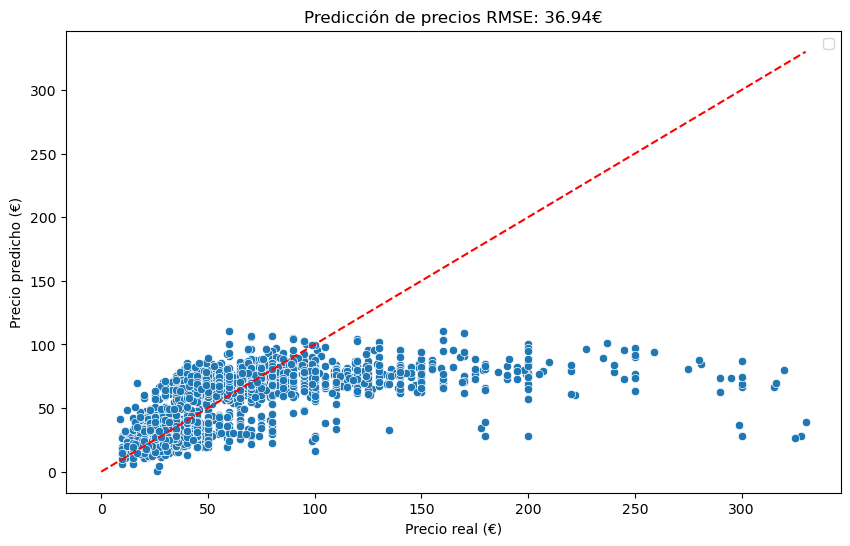

In [18]:
# obtenemos el mejor modelo y lo probamos en el conjunto de set
modelo_final = grid_lin_3.best_estimator_
y_predicho = modelo_final.predict(X_test_r)

# metricas para ver resultados
rmse_test = np.sqrt(mean_squared_error(y_test_r, y_predicho))
r2_test = r2_score(y_test_r, y_predicho)

print(f"RMSE: {rmse_test:.2f} euros")
print(f"R2:   {r2_test:.4f}")

# scatterplot para comprobar la prediccion
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_r, y=y_predicho)
valor_max = max(y_test_r.max(), y_predicho.max())
plt.plot([0, valor_max], [0, valor_max], 'r--')

plt.title(f'Predicción de precios RMSE: {rmse_test:.2f}€')
plt.xlabel('Precio real (€)')
plt.ylabel('Precio predicho (€)')
plt.legend()

plt.show()

# 3.3 Mejoras al modelo: 

En la evaluación inicial del modelo de regresión lineal, se obtuvo un coeficiente de determinación $R^2 \approx 0.32$. 
Al analizar la distribución de los precios de AirBnB, se observa un fuerte sesgo a la derecha, lo que dificulta que el modelo lineal ajuste correctamente. Como mejora, realizaremos el entrenamiento de nuevo pero transformando la variable objetivo price con np.log1p.

In [19]:
# aplicamos log1p a la variable objetivo
y_reg_log = np.log1p(df_p99['price'])

# volvemos a dividir los datos pero con el log1p aplicado
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X_transformado, y_reg_log, test_size=0.2, random_state=42
)

# entramos y predecimos los resultados
modelo_lin_log = LinearSVR(C=16.5, random_state=42, max_iter=100000)
modelo_lin_log.fit(X_train_log, y_train_log)
y_pred_log = modelo_lin_log.predict(X_test_log)

# revertimos el log1p
y_test_real = np.expm1(y_test_log)
y_pred_real = np.expm1(y_pred_log)

# metricas
rmse_log = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
r2_log = r2_score(y_test_real, y_pred_real)

print(f"RMSE: {rmse_log:.2f} euros")
print(f"R2:   {r2_log:.4f}")

RMSE: 36.54 euros
R2:   0.3341


# Resultados finales

Al comparar los resultados observamos que la simple transformación de la variable objetivo permite que el modelo lineal capture mejor la tendencia de los datos, el incluir esta mejora me ha dado a entender la importancia de realizar un mejor análisis exploratorio de datos al principio del que he realizado (He decidido no modificarlo ya que creo que es una parte importante del trabajo realizado, el ver los errores cometidos), ya que simplemente visualizando la distribución de la variable price habría identificado la necesidad de aplicar una transformación logaritmica en vez de darme cuenta de que era necesario al visualizar los resultados

Tras aplicar la mejora, observamos que:
- Modelo Óptimo: El modelo lineal mejora a un rendimiento de un $R^2$ de 0.3341 y un RMSE de 36.54€.
- Analizando el scatterplot, pese que el modelo ha mejorado vemos que sigue sin poder predecir correctamente los alojamientos mas caros

RMSE: 36.94 euros
R2:   0.3191


C:\Users\alexh\AppData\Local\Temp\ipykernel_25328\484141421.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


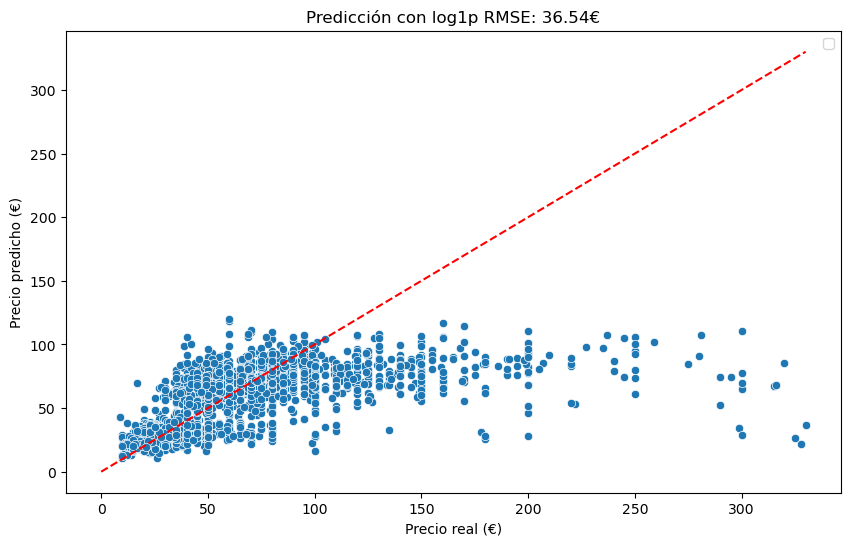

In [20]:
# obtenemos el mejor modelo y lo probamos en el conjunto de set
y_predicho_log = modelo_lin_log.predict(X_test_log)
y_test_real = np.expm1(y_test_log)
y_pred_real = np.expm1(y_pred_log)
# metricas para ver resultados
rmse_log = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
r2_log = r2_score(y_test_real, y_pred_real)

print(f"RMSE: {rmse_test:.2f} euros")
print(f"R2:   {r2_test:.4f}")

# scatterplot para comprobar la prediccion
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_real, y=y_pred_real)
valor_max = max(y_test_real.max(), y_pred_real.max())
plt.plot([0, valor_max], [0, valor_max], 'r--')

plt.title(f'Predicción con log1p RMSE: {rmse_log:.2f}€')
plt.xlabel('Precio real (€)')
plt.ylabel('Precio predicho (€)')
plt.legend()

plt.show()